## Part 4: Model Training Worflow

This notebook outlines the overall machine learning workflow, including preparing the dataset, loading the pretrained model, and training and validating the model on a few data points.

In [119]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import numpy as np
import random
import satlaspretrain_models
import matplotlib.pyplot as plt
import rasterio as rio

import torch.optim as optim
import torch.nn.functional as F

from scipy import ndimage

##### 1. Dataset and Dataloader

We are aware that the location of a fire may depend on its surroundings, and there may be some correlation between a few fire events. However, our task does not yet consider spatial correlation. First, we treat each fire event as an independent sample and focus on the binary segmentation task when training the model.

In [120]:
data_folder = f"ml/data_example"
img_dir = f'{data_folder}/post_fire'
mask_dir = f'{data_folder}/masks'

In [121]:
### ==============================================================================================
### Split train, validation and test samples
### These samples are raw satellite imagery from the Google Earth
### ==============================================================================================
def split_dataset(img_dir, train_ratio = 0.8, val_ratio = 0.1, test_ratio = 0.1, seed = 0):
    """Split the dataset into train, validation and test according to ratio"""
    data = os.listdir(img_dir)
    data_size = len(data)

    train_size = int(data_size * train_ratio)
    val_size = int(data_size * val_ratio)
    test_size = int(data_size * test_ratio)
    print(f"Training data size {train_size}, Validation data size {val_size}, Testing data size {test_size}")

    # Shuffle all images and split into three subsets
    random.seed(seed)
    random.shuffle(data)
    train_data = data[:train_size]
    val_data = data[train_size : train_size+val_size]
    test_data = data[train_size+val_size : data_size]

    return train_data, val_data, test_data

In [122]:
train_data, val_data, test_data = split_dataset(img_dir=img_dir)

Training data size 16, Validation data size 2, Testing data size 2


In [123]:
### ==============================================================================================
### Process raw images by filling in NaNs, normalizing values, cropping images, and mapping channels
### ==============================================================================================
class FireDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_list, transforms):
        super().__init__()
        self.img_dir = img_dir
        self.mask_dir = mask_dir   # 0, 1 unburned or burned
        self.img_list = img_list
        self.transforms = transforms

    def __len__(self):
        return len(self.img_list)

    def fill_norm(self, data):

        filled_data = np.zeros_like(data)

        for idx in range(data.shape[0]):
            band = data[idx,:, :].copy()   # 2d

            mask = np.isnan(band)  # True is nan
            if np.any(mask):
                # Replace nan with nearest non-nan values
                indices = ndimage.distance_transform_edt(mask, return_distances=False, return_indices=True)
                band = band[tuple(indices)]

            norm_band = np.zeros_like(band)
            if idx < 3:
                # Perform normalization for RGB -- divided by 255
                norm_band = (band / 255.0).clip(0.0, 1.0)
            else:
                # Normalize other bands, such as near infrared, shortwave infrared
                norm_band = (band / 8160.0).clip(0.0, 1.0)

            filled_data[idx] = norm_band

        return filled_data

    def __getitem__(self, idx):
        file_name = self.img_list[idx]

        img_path = os.path.join(self.img_dir, file_name)
        mask_path = os.path.join(self.mask_dir, file_name)

        # Read fire event raw files, fill NaNs, normalization
        with rio.open(img_path) as img:
            img_data = img.read().astype(np.float32)
            img_data[img_data == img.nodata] = np.nan
            img_data = self.fill_norm(img_data)

        # Read fire masks
        with rio.open(mask_path) as mask:
            mask_data = mask.read()

        img_tensor = self.mapping(img_data)
        mask_tensor = torch.from_numpy(mask_data).long().squeeze()

        # Apply transformation
        if self.transforms:
            img_tensor = self.transforms(img_tensor)
            mask_tensor = self.transforms(mask_tensor)

        return img_tensor, mask_tensor

    def mapping(self, data):
        # Prepare image tensor with shape (9, H, W) for Satlas multi-band model
        # Satlas (multi-band) expects [TCI_R, TCI_G, TCI_B, B05, B06, B07, B08, B11, B12]
        # Band order that I saved: [TCI_R, TCI_G, TCI_B, B8, B12]
        H, W = data.shape[1], data.shape[2]
        out = np.zeros((9, H, W), dtype=np.float32)

        TCI_R, TCI_G, TCI_B, B8, B12 = data
        out[0] = TCI_R  # Red
        out[1] = TCI_G  # Green
        out[2] = TCI_B  # Blue
        out[6] = B8  # NIR
        out[8] = B12 # SWIR

        return torch.from_numpy(out).float()

In [124]:
### ==============================================================================================
### Create dataset -- processing raw images
### ==============================================================================================
transform = transforms.RandomCrop(224, padding=4)

train_dataset = FireDataset(img_dir=img_dir, mask_dir=mask_dir, img_list=train_data, transforms=transform)
val_dataset = FireDataset(img_dir=img_dir, mask_dir=mask_dir, img_list=val_data, transforms=transform)
test_dataset = FireDataset(img_dir=img_dir, mask_dir=mask_dir, img_list=test_data, transforms=transform)

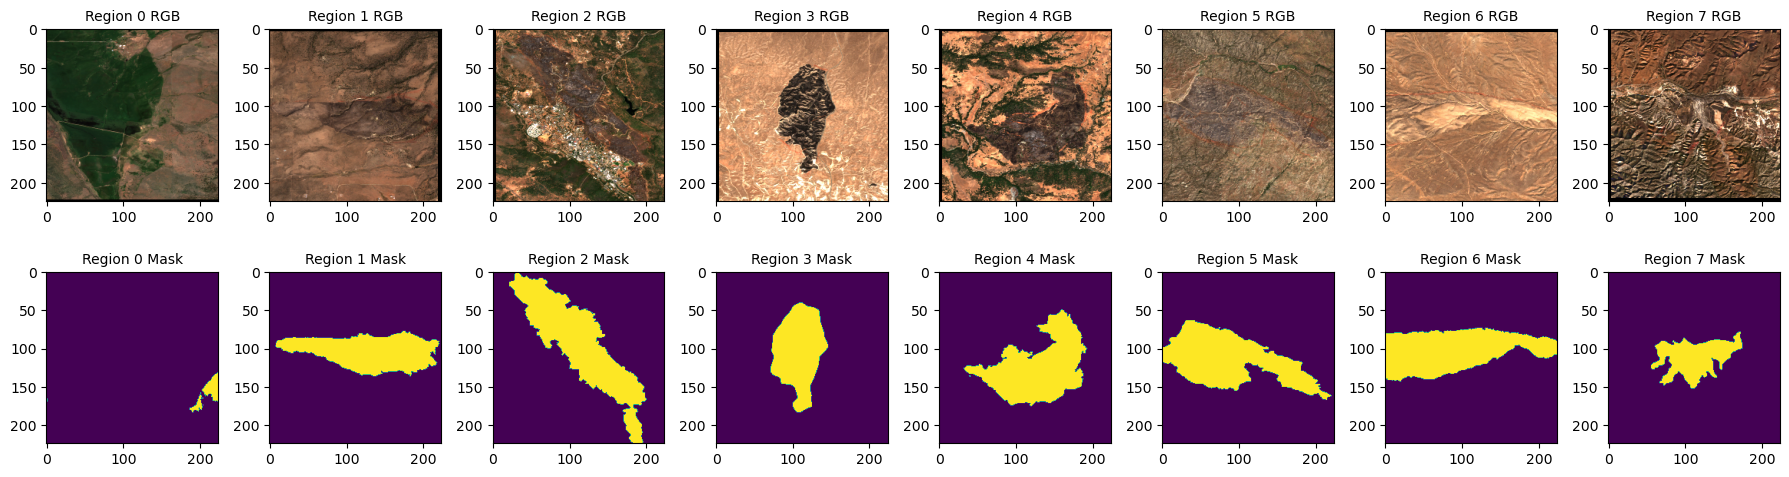

In [125]:
# Visualize few samples
fig, ax = plt.subplots(2, 8, figsize=(18, 5))
for i in range(8):
    data, target = train_dataset[i]

    image = data.numpy()
    target = target.numpy()

    rgb = image[:3]
    rgb = np.rollaxis(rgb, 0, rgb.ndim)  # (C, H, W) -> (H, W, C)
    ax[0, i].imshow(rgb)
    ax[0, i].set_title(f"Region {i} RGB", fontsize=10)
    ax[1, i].imshow(target)
    ax[1, i].set_title(f"Region {i} Mask", fontsize=10)

plt.tight_layout()
plt.show()

In [126]:
### ==============================================================================================
### Create dataloaders -- processing samples using mini-batch
### ==============================================================================================
batch_size = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
  num_workers = 4
else:
  num_workers = 0

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

##### 2. Load Pretrained Model -- Remote Sensing Foundation Models

SatlasPretrain is a large-scale, pretrained dataset for understanding remote sensing images. SatlasPretrain models consist of three main components: a backbone, a feature pyramid network (FPN), and a prediction head.

* **Model selection**: our selected model can learn strong representations of individual satellite images with multispectral data (9 bands), overcoming the need for historical pre-fire event images. It avoids computing the difference in normalized burn ratios and encourages the model to make predictions on real-time images.

* **Model Architecture**:


More information:

https://pypi.org/project/satlaspretrain-models/

https://github.com/allenai/satlaspretrain_models/blob/main/demo.ipynb

In [127]:
### ==============================================================================================
### Model initialization
### ==============================================================================================
# Initialize weights
weights_manager = satlaspretrain_models.Weights()

# Select pretrained model on Sentinel-2, choose segmentation head for binary classes
# Load backbone + FPN
model = weights_manager.get_pretrained_model(model_identifier="Sentinel2_SwinB_SI_MS",
                                             fpn=True,
                                             num_categories=2,
                                             head=satlaspretrain_models.Head.SEGMENT,
                                             device=device).to(device)

In [ ]:
### ==============================================================================================
### Check the model architecture
### ==============================================================================================
# https://github.com/allenai/satlas/blob/main/ModelArchitecture.md

# model

for name, param in model.named_parameters():
    print(name, param.shape, param.requires_grad)

backbone.backbone.features.0.0.weight torch.Size([128, 9, 4, 4]) True
backbone.backbone.features.0.0.bias torch.Size([128]) True
backbone.backbone.features.0.2.weight torch.Size([128]) True
backbone.backbone.features.0.2.bias torch.Size([128]) True
backbone.backbone.features.1.0.norm1.weight torch.Size([128]) True
backbone.backbone.features.1.0.norm1.bias torch.Size([128]) True
backbone.backbone.features.1.0.attn.logit_scale torch.Size([4, 1, 1]) True
backbone.backbone.features.1.0.attn.qkv.weight torch.Size([384, 128]) True
backbone.backbone.features.1.0.attn.qkv.bias torch.Size([384]) True
backbone.backbone.features.1.0.attn.proj.weight torch.Size([128, 128]) True
backbone.backbone.features.1.0.attn.proj.bias torch.Size([128]) True
backbone.backbone.features.1.0.attn.cpb_mlp.0.weight torch.Size([512, 2]) True
backbone.backbone.features.1.0.attn.cpb_mlp.0.bias torch.Size([512]) True
backbone.backbone.features.1.0.attn.cpb_mlp.2.weight torch.Size([4, 512]) True
backbone.backbone.featur

#### Setup training process



source: https://blog.paperspace.com/image-segmentation-using-segmentation_models_pytorch/

In [128]:
lr = 1e-4
epochs = 10

optimizer = optim.Adam(model.parameters(), lr = lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [129]:
# https://medium.com/data-scientists-diary/implementation-of-dice-loss-vision-pytorch-7eef1e438f68

def dice_loss(outputs, targets):
    num_classes=2
    probs = F.softmax(outputs[0], dim=1)  # Compute prob across number of classes

    # Resize output to match target:
    if probs.shape[2:] != targets.shape[1:]:
        probs = F.interpolate(probs, size=targets.shape[1:], mode='bilinear', align_corners=False)

    # One-hot encoding with tensor shape (N, C, H, W)
    targets_one_hot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float().to(targets.device)

    dims = (0, 2, 3)
    epsilon = 1e-6
    # Compute dice for fire area and background
    intersection = torch.sum(probs * targets_one_hot, dim=dims)
    cardinality = torch.sum(probs + targets_one_hot, dim=dims)
    union = cardinality - intersection
    dice_per_class = (2. * intersection + epsilon) / (cardinality + epsilon)
    iou_per_class = (intersection + epsilon) / (union + epsilon)

    # Handle imbalanced classes
    class_counts = torch.sum(targets_one_hot, dim=dims)
    class_weights = 1.0 / (class_counts + epsilon)
    class_weights = class_weights / class_weights.sum()
    weights = torch.tensor(class_weights, device=targets.device)

    # Weighted dice
    weighted_dice = torch.sum(dice_per_class * weights)
    weighted_iou = torch.sum(iou_per_class * weights) / weights.sum()

    # return dice loss
    return 1.0 - weighted_dice, weighted_dice, weighted_iou

In [130]:
def train(model, train_dataloader, optimizer, criterion, device):
    model.train()
    sum_loss = 0

    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss, _, _ = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        num_samples = inputs.size(0)
        sum_loss += loss.item() * num_samples

    average_loss = sum_loss / len(train_dataloader.dataset)
    return average_loss # avg epoch loss

In [131]:
def validate(model, val_dataloader, criterion, device):
    model.eval()
    sum_loss = 0
    sum_dice = 0
    sum_iou = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss, dice_score, iou = criterion(outputs, targets)
            num_samples = inputs.size(0)
            sum_loss += loss.item() * num_samples
            sum_dice += dice_score.item() * num_samples
            sum_iou += iou.item() * num_samples

    average_loss = sum_loss / len(val_dataloader.dataset)
    average_dice = sum_dice / len(val_dataloader.dataset)
    average_iou = sum_iou / len(val_dataloader.dataset)
    return average_loss, average_dice, average_iou

In [132]:
def run(model, epochs, train_dataloader, val_dataloader, optimizer, criterion, scheduler, device):
    for epoch in range(1, epochs + 1):
        train_loss = train(model,
                           train_dataloader=train_dataloader,
                           optimizer=optimizer,
                           criterion=criterion,
                           device=device,)
        val_loss, val_dice, val_iou = validate(model,
                            val_dataloader=val_dataloader,
                            criterion=criterion,
                            device=device,)
        scheduler.step()
        print(f"Epoch [{epoch}/{epochs}]: train loss {train_loss} | val loss {val_loss} | val dice {val_dice} | val iou {val_iou}")

In [133]:
run(model, epochs, train_dataloader, val_dataloader, optimizer, dice_loss, scheduler, device)

/tmp/ipykernel_2858234/1172169560.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(class_weights, device=targets.device)


Epoch [1/10]: train loss 0.6757689714431763 | val loss 0.6208277940750122 | val dice 0.3791722059249878 | val iou 0.24162457883358002
Epoch [2/10]: train loss 0.6749180555343628 | val loss 0.6112707853317261 | val dice 0.3887292444705963 | val iou 0.2484568953514099
Epoch [3/10]: train loss 0.6671770811080933 | val loss 0.5842634439468384 | val dice 0.41573652625083923 | val iou 0.2685198485851288
Epoch [4/10]: train loss 0.6430766880512238 | val loss 0.5537054538726807 | val dice 0.44629454612731934 | val iou 0.2922942340373993
Epoch [5/10]: train loss 0.6148986220359802 | val loss 0.5260352492332458 | val dice 0.47396475076675415 | val iou 0.3163425624370575
Epoch [6/10]: train loss 0.5919656455516815 | val loss 0.4992821216583252 | val dice 0.5007178783416748 | val iou 0.34083664417266846
Epoch [7/10]: train loss 0.5676153302192688 | val loss 0.46931159496307373 | val dice 0.5306884050369263 | val iou 0.36894598603248596
Epoch [8/10]: train loss 0.5486176311969757 | val loss 0.45196

In [134]:
model.eval()
with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs[0], dim=1)

In [135]:
print(f"Inputs shape {inputs.shape}")  # num_samples, channels, height, width
print(f"First sample input shape {inputs[0].shape}")
print(f"First sample RGB channel {inputs[0][:3].shape}")
print(f"Predictions shape {preds.shape}")

Inputs shape torch.Size([2, 9, 224, 224])
First sample input shape torch.Size([9, 224, 224])
First sample RGB channel torch.Size([3, 224, 224])
Predictions shape torch.Size([2, 224, 224])


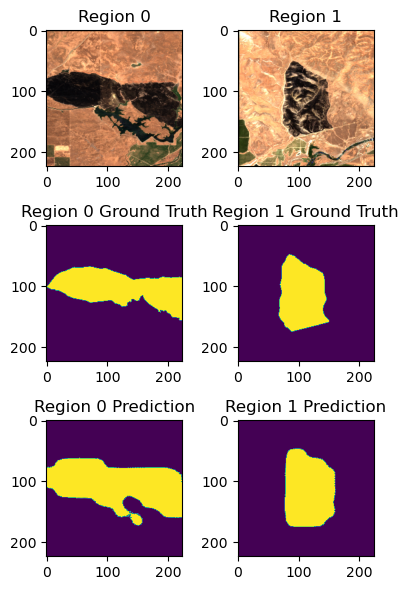

In [137]:
num_samples = 2
fig, ax = plt.subplots(3, num_samples, figsize=(4, 6))
for i in range(num_samples):
    img = inputs[i].cpu()
    rgb = img[:3]
    rgb = rgb.permute(1, 2, 0).numpy()

    ground_truth = targets[i].cpu().numpy()
    prediction = preds[i].detach().cpu().numpy()
    ax[0, i].imshow(rgb)
    ax[0, i].set_title(f"Region {i}")

    ax[1, i].imshow(ground_truth)
    ax[1, i].set_title(f"Region {i} Ground Truth")

    ax[2, i].imshow(prediction)
    ax[2, i].set_title(f"Region {i} Prediction")

plt.tight_layout()
plt.show()